In [1]:
import os
import math
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
#import cartopy.feature as cfeature
from cmocean import cm

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.calval as ca

---
### Input parameters

In [2]:
# site directories
root_dir = '/home1/datawork/slgentil/parcels/'
site = 'med_south'           # 'californie', 'med_north', 'med_south'
season = 'spring'             # 'spring', 'summer', 'autumn', 'winter'
dl = 8
speed = 5

---
### Methods

In [3]:
def plot_pretty(bbox, swot_tracks=False, trails=None, bg_var=None, figsize=(10,10),
                offline=False, fig_dir=None, fig_prefix=None, date=None, **kwargs):
 
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if fig_dir is None:
        fig_dir = os.environ['SCRATCH']+'/figs/'
    if not os.path.isdir(fig_dir):
        os.mkdir(fig_dir)
    if fig_prefix is None:
        fig_prefix = 'image'
    figname = fig_dir+fig_prefix+'.png'
    
    if offline:
        import dask
        dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
        
        
    # init figure, axe
    fig, ax = plt.subplots(1, 1, 
                           #subplot_kw={'projection': crs},
                           subplot_kw={'projection': ccrs.PlateCarree()},
                           figsize=figsize,
                          )
    ax.set_extent(bbox)
        
    if bg_var is not None:
        bg_kwargs = kwargs['bg_kwargs']
        cm= bg_var.plot.pcolormesh(ax=ax,x="XC",y="YC", extend="neither",
                                   add_colorbar=False, **bg_kwargs)
        # colorbar in pcolormesh has not the right size
        #ax.set_aspect('auto', adjustable=None)  # grid distorded
        # add colorbar with the right size
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
        fig.add_axes(ax_cb)
        fig.colorbar(cm, cax=ax_cb)
    
    if swot_tracks is not None:
        # init for swot tracks
        central_lon = (bbox[0]+bbox[1])*0.5
        central_lat = (bbox[2]+bbox[3])*0.5

        polygon = Polygon([(bbox[0], bbox[2]), 
                           (bbox[1], bbox[2]), 
                           (bbox[1], bbox[3]), 
                           (bbox[0], bbox[3]), 
                           (bbox[0], bbox[2]),
                          ])
        
        crs = ccrs.AlbersEqualArea(central_lon, central_lat)
        crs_proj4 = crs.proj4_init
        gdf = tracks["swath"]
        gdf_clipped = gpd.clip(gdf, polygon)
        gdf_crs = gdf_clipped.to_crs(crs_proj4)
        ax.add_geometries(gdf_crs['geometry'],
                          crs=crs,
                          facecolor='grey', 
                          edgecolor='black',
                          alpha=0.5,
                         )
    # set grid lines
    gl = ax.gridlines(draw_labels=True)
    # Hide the right and top axis graduation
    gl.top_labels = False
    gl.right_labels = False
    
    ax.coastlines(resolution='10m')
    if trails is not None:
        drifter_kwargs = kwargs['drifter_kwargs']
        if trails.index.unique().size>1:
            trails.groupby('trajectory').apply(plot_trajectory, ax=ax, **drifter_kwargs)
        else:
            #date = date.strftime('%Y-%m-%d_%HH')
            ax.plot(trails.lon, trails.lat, '.',**drifter_kwargs)
            
    if date is not None:
        ax.set_title(date.strftime('%Y-%m-%d_%HH'))
            
    if offline:           
        fig.savefig(figname, dpi=150, bbox_inches = 'tight')
        plt.close(fig)

    return fig, ax

In [4]:
def plot_trajectory(df, 
                    ax=None, 
                    flag_drifters=0,
                    **kwargs,
                   ):
    """ plot single drifter trajectory
    
    Parameters
    ----------
    df: pandas.Dataframe
    ax: pyplot axis, optional
    flag_drifters: int, optional
        used to distinguish drifters 
    **kwargs: optional
        options for plot method
    """
    df = df.sort_index()
    dr_id = int(df['trajectory'].unique()[0])
    dkwargs = dict(ms=1)
    dkwargs.update(kwargs)
    if ax is None:
        fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    ax.plot(df.lon, df.lat, **dkwargs)
    return ax

In [5]:
def format_info(t_start, t_end, t_released, t_delta):
    print('start={}  /  end={}  /  released={} / delta={} days'
          .format(t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                  t_released.strftime("%Y-%m-%d:%H"),
                  t_delta.days
                 )
         )

---
### init parameters

In [6]:
run_dir = os.path.join(root_dir, site+'_'+season+"/run/")
simu_name = 'dl'+str(dl)+'.speed'+str(speed)
# for back and forth release
simu_name = simu_name+'.bf'

bbox, lon_i, lat_i = ca.get_site_limits(site)
lonmin = bbox[0]
lonmax = bbox[1]
latmin = bbox[2]
latmax = bbox[3]

### Load SWOT tracks

In [7]:
tracks = ut.load_swot_tracks()

---
### Load trajectories

In [8]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
df_trails = pa.load_nc(run_dir, index='time', step_tile=simu_name, persist=True).compute().dropna()

---
### Load llc

In [9]:
ds_llc = xr.open_dataset(os.path.join(run_dir, "data_000/llc.nc")).chunk(chunks={"time": 1})

---
### compute time parameters

In [10]:
t_start = df_trails.index.min()                     # start time of the simulation
t_end = df_trails.index.max()                       # end time of the simulation

# Compute the first time where all the drifters are released
nb_flt = df_trails['trajectory'].unique().size      # Compute number of released drifters
_df = pd.Index(df_trails.index).value_counts()      # get number of rows per time
_df = _df[_df == nb_flt]                            # Keep lines with nb_flt number of rows
t_released = _df.index.min()                        # Keep  the min date

#t_delta = t_end - t_released                       # length of the trails behind the drifter
t_delta=pd.Timedelta(days=5)                        # length of the trails behind the drifter
t_range = pd.date_range(t_start, t_end+pd.Timedelta(hours=1), freq=pd.Timedelta(hours=1))  

format_info(t_start, t_end, t_released, t_delta)

start=2012-05-15:00  /  end=2012-06-06:01  /  released=2012-05-15:19 / delta=5 days


---
### Plots

(<Figure size 720x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'2012-06-01_01H'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

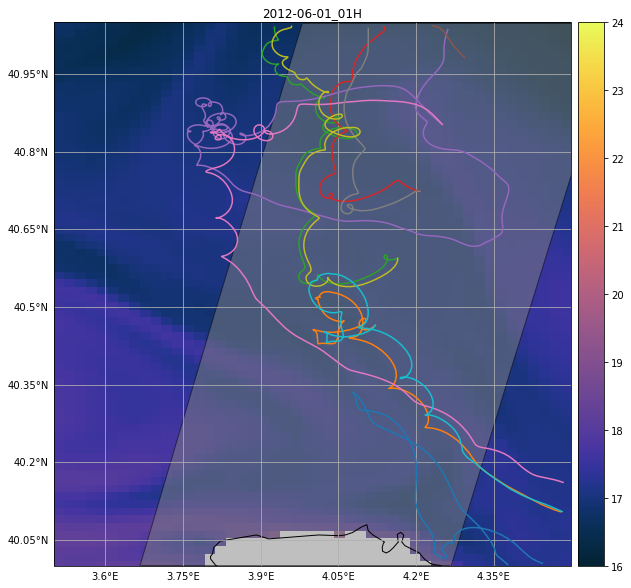

In [11]:
# Plot last t_delta days of the simulation
vmin = math.ceil(ds_llc['SST'].min().values)
vmax = math.floor(ds_llc['SST'].max().values)

kwargs = dict(
              #drifter_kwargs={"color": "white"},
              drifter_kwargs={},
              bg_kwargs = {'vmin': vmin,'vmax': vmax, 'cmap':cm.thermal}
             )

trails = df_trails.loc[(df_trails.index>=t_start)&(df_trails.index<=t_end)]
bg_var = ds_llc['SST'].sel(time=t_start)
plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, 
            date=t_end-t_delta, figsize=(10,10), **kwargs)

In [12]:
# Animate trails during the last t_delta days of the simulation
fig_dir=os.path.join(root_dir, site+'_'+season+"/figs/")
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
os.system('rm -Rf '+fig_dir+'*.png')
#os.system('rm -Rf '+fig_dir+'trails_'+simu_name+'.mp4')
               
for img, t in enumerate(t_range):
    trails = df_trails.loc[(df_trails.index>=t_range[0])&(df_trails.index<=t)]
    bg_var = ds_llc['SST'].sel(time=t)
    plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, 
                figsize=(10,10), offline=True, 
                fig_dir=fig_dir,
                fig_prefix=simu_name+'.{:03d}'.format(img), 
                date=t, **kwargs)

    # Movie with ffmpeg
#command = 'cd '+fig_dir+';ffmpeg -y -framerate 25 -i '+simu_name+ \
#            '.%03d.png -vcodec mpeg2video  trails_'+simu_name+'.mov'
command = 'cd '+fig_dir+';ffmpeg -y -framerate 20 -i '+simu_name+ \
            '.%03d.png  -target pal-dvd -qscale 0 trails_'+simu_name+'.mpg'
os.system(command)

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavfor

0

(<Figure size 720x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'2012-05-15_19H'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

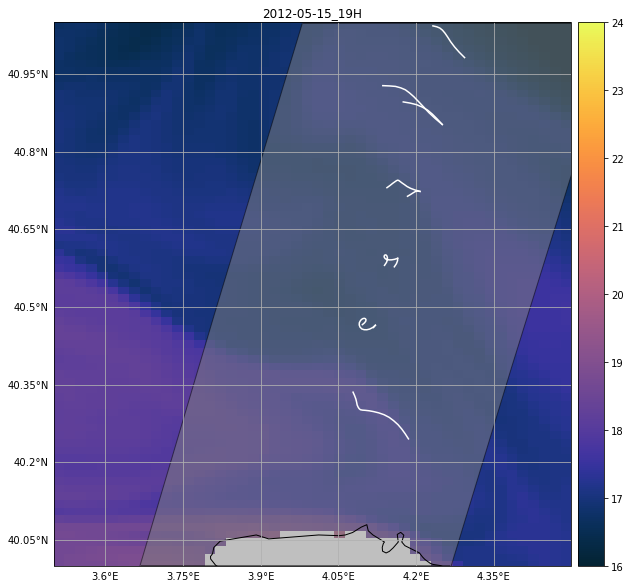

In [13]:
# Plot trace of t_delta days behind the drifter
kwargs = dict(
              drifter_kwargs={"color": "white"},
              #drifter_kwargs={},
              bg_kwargs = {'vmin': vmin,'vmax': vmax, 'cmap':cm.thermal}
             )

trails = df_trails.loc[(df_trails.index>=t_released-t_delta)&(df_trails.index<=t_released)]
bg_var = ds_llc['SST'].sel(time=t_released)
plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, 
            date=t_released, figsize=(10,10), **kwargs)

In [14]:
# Animate drifters with trace of t_delta days
fig_dir=os.path.join(root_dir, site+'_'+season+"/figs/")
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
os.system('rm -Rf '+fig_dir+'*.png')
#os.system('rm -Rf '+fig_dir+'trails_'+simu_name+'.mp4')

for img, t in enumerate(t_range):
    trails = df_trails.loc[(df_trails.index>=t-t_delta)&(df_trails.index<=t)]
    bg_var = ds_llc['SST'].sel(time=t)
    plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, 
                figsize=(10,10), offline=True, 
                fig_dir=fig_dir,
                fig_prefix=simu_name+'.{:03d}'.format(img), 
                date=t, **kwargs)

    # Movie with ffmpeg
#command = 'cd '+fig_dir+';ffmpeg -y -framerate 25 -i '+simu_name+ \
#            '.%03d.png -vcodec mpeg2video  trails_'+simu_name+'.mov'
command = 'cd '+fig_dir+';ffmpeg -y -framerate 20 -i '+simu_name+ \
            '.%03d.png  -target pal-dvd -qscale 0 small_trails_'+simu_name+'.mpg'
os.system(command)

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavfor

0

(<Figure size 720x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'2012-05-15_19H'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

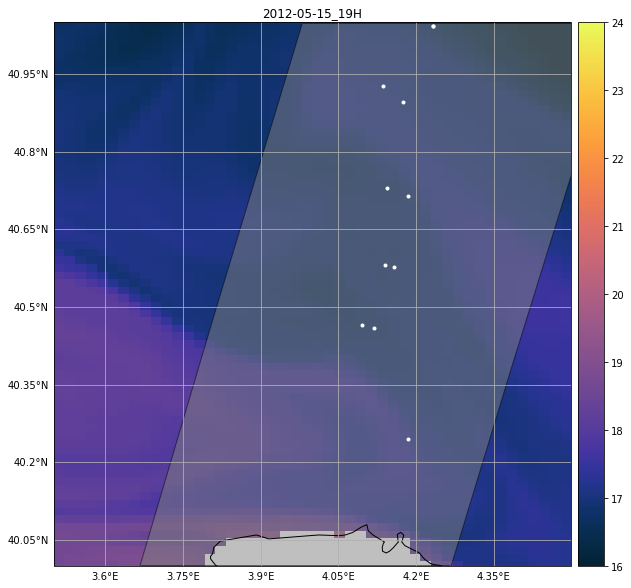

In [15]:
#Plot time of the last released drifter
kwargs = dict(
              drifter_kwargs={"color": "white"},
              #drifter_kwargs={},
              bg_kwargs = {'vmin': vmin,'vmax': vmax, 'cmap':cm.thermal,
                          }
             )

trails = df_trails.loc[(df_trails.index==t_released)]
bg_var = ds_llc['SST'].sel(time=t_released)
plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, 
            date=t_released, figsize=(10,10), **kwargs)

In [16]:
# Animate drifters during the last t_delta days of the simulation

fig_dir=os.path.join(root_dir, site+'_'+season+"/figs/")
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
os.system('rm -Rf '+fig_dir+'*.png')
#os.system('rm -Rf '+fig_dir+'drifters_'+simu_name+'.mpg')
               
for img, t in enumerate(t_range):
    trails = df_trails.loc[(df_trails.index==t)]
    bg_var = ds_llc['SST'].sel(time=t)
    plot_pretty(bbox, swot_tracks=tracks, trails=trails, bg_var=bg_var, figsize=(10,10), 
                offline=True, 
                fig_dir=fig_dir, 
                fig_prefix=simu_name+'.{:03d}'.format(img), 
                date=t,**kwargs)

# Movie with ffmpeg
#command = 'cd '+fig_dir+';ffmpeg -y -framerate 25 -i '+simu_name+ \
#            '.%03d.png -vcodec mpeg2video  drifters_'+simu_name+'.mov'
command = 'cd '+fig_dir+';ffmpeg -y -framerate 20 -i '+simu_name+ \
            '.%03d.png  -target pal-dvd -qscale 0 drifters_'+simu_name+'.mpg'

os.system(command)

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavfor

0

In [17]:
# clean figs directory
os.system('rm -Rf '+fig_dir+'*.png')

0